# Capítulo 6 · Diagnóstico de supuestos del modelo OLS

**Objetivo:** evaluar los principales **supuestos del modelo de regresión lineal** ajustado en capítulos previos:

- Linealidad y forma funcional
- Normalidad de residuos
- Homocedasticidad
- Independencia (autocorrelación)
- Influencia y valores atípicos
- Multicolinealidad (VIF)

Este cuaderno genera **todos los gráficos diagnósticos** y tablas necesarias para interpretar la calidad del ajuste OLS.


## 6.1 Datos y modelo base

Reutilizamos las **variables candidatas** seleccionadas con el mismo criterio de los capítulos 3–5
(correlación alta con `SalePrice` y baja colinealidad entre predictores).

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Localizar dataset
CANDIDATE_PATHS = [Path('data/ames_housing.csv'), Path('AmesHousing.csv')]
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError('No se encontró data/ames_housing.csv ni AmesHousing.csv')

df = pd.read_csv(DATA_PATH)

target = "SalePrice"

# Numéricas y limpieza de infinitos
num_df = df.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# Pool de variables según correlación absoluta con SalePrice
corr_abs = num_df.corr(numeric_only=True)[target].dropna().abs().sort_values(ascending=False)
pool = [c for c in corr_abs.index if c != target][:15]

sel = []
for v in pool:
    if not sel:
        sel.append(v)
        continue
    ok = True
    for u in sel:
        r = abs(num_df[[v, u]].dropna().corr().iloc[0, 1])
        if r > 0.85:
            ok = False
            break
    if ok:
        sel.append(v)
    if len(sel) >= 12:
        break

# Datos finales
data = num_df[[target] + sel].dropna()
y = data[target].values
X = sm.add_constant(data[sel].values, has_constant="add")

sel, X.shape, y.shape

(['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Total Bsmt SF',
  '1st Flr SF',
  'Year Built',
  'Full Bath',
  'Year Remod/Add',
  'Garage Yr Blt',
  'Mas Vnr Area',
  'TotRms AbvGrd',
  'Fireplaces'],
 (2748, 13),
 (2748,))

Mostramos las variables utilizadas en el modelo:

In [2]:
pd.DataFrame({"Variable": sel, "abs(corr SalePrice)": corr_abs[sel].values}).round(3)

,Variable,abs(corr SalePrice)
0,Overall Qual,0.799
1,Gr Liv Area,0.707
2,Garage Cars,0.648
3,Total Bsmt SF,0.632
4,1st Flr SF,0.622
5,Year Built,0.558
6,Full Bath,0.546
7,Year Remod/Add,0.533
8,Garage Yr Blt,0.527
9,Mas Vnr Area,0.508


## 6.2 Ajuste del modelo y residuos

Ajustamos el modelo OLS y extraemos:

- Valores ajustados (fitted)
- Residuos
- Residuos estandarizados


In [3]:
ols = sm.OLS(y, X).fit()

fitted = ols.fittedvalues
resid = ols.resid
influence = ols.get_influence()
resid_student = influence.resid_studentized_internal

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     909.9
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        01:41:21   Log-Likelihood:                -32698.
No. Observations:                2748   AIC:                         6.542e+04
Df Residuals:                    2735   BIC:                         6.550e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.258e+06   9.42e+04    -13.357      0.000   -1.44e+06   -1.07e+06
x1          1.875e+04    812.249     23.088      0.000    1.72e+04    2.03e+04
x2            49.1831      3.015     16.315      0.000      43.272      55.094
x3          1.385e+04   1516.938      9.128      0.000    1.09e+04    1.68e+04
x4            22.2139      2.812      7.899      0.000      16.700      27.728
x5            12.1134      3.212      3.772      0.000       5.816      18.411
x6           216.4772     46.743      4.631      0.000     124.822     308.132
x7         -7950.1848   1836.455     -4.329      0.000   -1.16e+04   -4349.205
x8           376.3075     47.104      7.989      0.000     283.945     468.670
x9            11.9275     55.913      0.213      0.831     -97.709     121.564
x10           35.7916      4.369      8.192      0.000      27.224      44.359
x11         -868.7341    766.437     -1.133      0.257   -2371.588     634.120
x12         8697.6657   1236.964      7.031      0.000    6272.187    1.11e+04
==============================================================================
Omnibus:                     1164.902   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           134958.524
Skew:                          -1.007   Prob(JB):                         0.00
Kurtosis:                      37.273   Cond. No.                     5.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 6.3 Gráfico de residuos vs. valores ajustados

Este gráfico permite evaluar:

- Linealidad (los residuos deberían oscilar alrededor de 0 sin patrón claro)
- Homocedasticidad (varianza aproximadamente constante a lo largo del eje de ajustados)


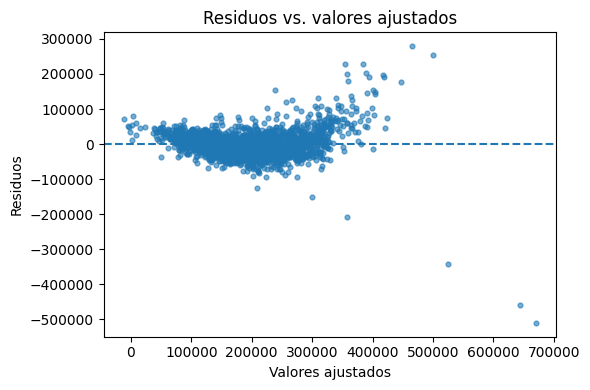

In [4]:
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, s=12, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs. valores ajustados")
plt.tight_layout()
plt.show()

## 6.4 Normalidad de residuos: histograma y QQ-plot

Evaluamos la aproximación a normalidad mediante:

- Histograma de residuos
- QQ-plot comparando con una distribución normal teórica


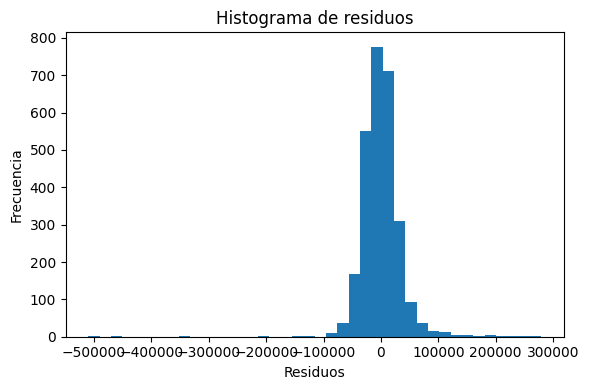

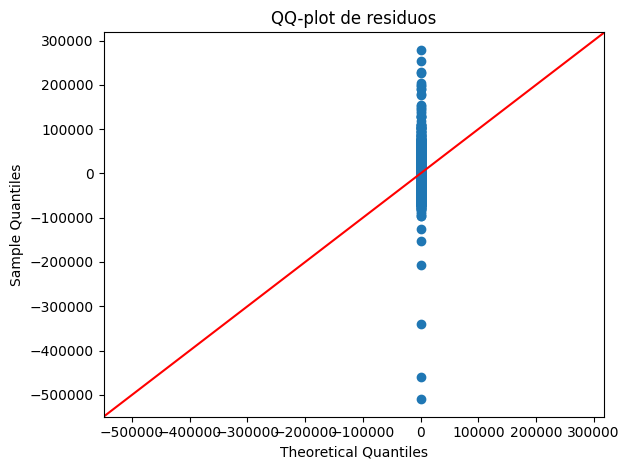

In [5]:
# Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(resid, bins=40)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos")
plt.tight_layout()
plt.show()

# QQ-plot
fig = sm.qqplot(resid, line="45")
plt.title("QQ-plot de residuos")
plt.tight_layout()
plt.show()

## 6.5 Prueba de homocedasticidad: Breusch–Pagan

Contrastamos:

- $H_0$: homocedasticidad (varianza constante de los errores)
- $H_1$: heterocedasticidad

Usamos la prueba de Breusch–Pagan sobre los residuos vs. predictores.

In [6]:
bp_test = het_breuschpagan(resid, X)

labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
bp_results = pd.Series(bp_test, index=labels)
bp_results

LM stat        7.051415e+02
LM p-value    3.497135e-143
F stat         7.867089e+01
F p-value     3.561338e-166
dtype: float64

> Interpretación: un p-valor pequeño (por ejemplo < 0.05) sugiere **rechazar** homocedasticidad y considerar remedios (transformaciones, HC3, modelos robustos, etc.).

## 6.6 Independencia de errores: estadístico de Durbin–Watson

El estadístico de Durbin–Watson toma valores cercanos a 2 bajo ausencia de autocorrelación:

- Cerca de 2: sin autocorrelación fuerte.
- Mucho menor que 2: autocorrelación positiva.
- Mucho mayor que 2: autocorrelación negativa.


In [7]:
dw = sm.stats.durbin_watson(resid)
dw

np.float64(1.534280417848114)

## 6.7 Influencia, leverage y distancias de Cook

Analizamos:

- **Leverage** (diagonal de la matriz sombrero): puntos con valores extremos en el espacio de predictores.
- **Distancia de Cook**: medida global de influencia de cada observación sobre los estimadores.

Un valor de Cook alto (por ejemplo, superior a $4/n$) puede indicar observaciones muy influyentes.


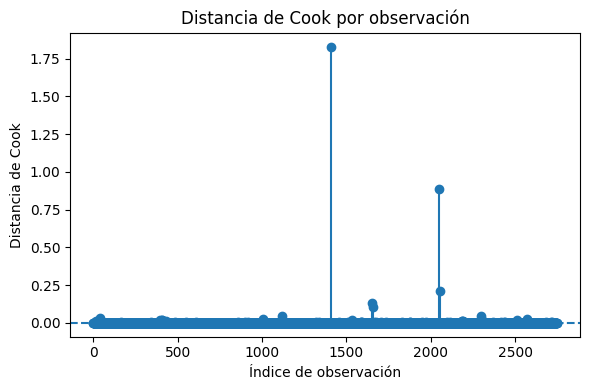

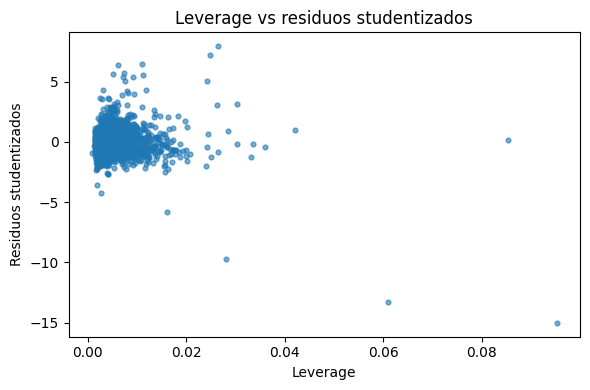

In [8]:
# Leverage y Cook's distance
lev = influence.hat_matrix_diag
cooks_d, _ = influence.cooks_distance

n = len(y)
threshold_cook = 4 / n

fig, ax = plt.subplots(figsize=(6,4))
ax.stem(range(n), cooks_d, basefmt=" ")
ax.axhline(threshold_cook, linestyle="--")
ax.set_xlabel("Índice de observación")
ax.set_ylabel("Distancia de Cook")
ax.set_title("Distancia de Cook por observación")
plt.tight_layout()
plt.show()

# Gráfico leverage vs residuos estudentizados
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(lev, resid_student, s=12, alpha=0.6)
ax.set_xlabel("Leverage")
ax.set_ylabel("Residuos studentizados")
ax.set_title("Leverage vs residuos studentizados")
plt.tight_layout()
plt.show()

## 6.8 Multicolinealidad: Factor de Inflación de la Varianza (VIF)

El **VIF** de cada predictor mide cuánta varianza adicional se introduce en el estimador de su coeficiente debido a la colinealidad:

- $VIF_j = 1$: sin colinealidad.
- $VIF_j \in [5,10)$: colinealidad moderada.
- $VIF_j \geq 10$: colinealidad severa (alerta).

Calculamos VIF para cada predictor (sin incluir la constante).

In [9]:
X_no_const = data[sel].values

vif_values = []
for j in range(X_no_const.shape[1]):
    vif = variance_inflation_factor(X_no_const, j)
    vif_values.append(vif)

vif_table = pd.DataFrame({
    "Variable": sel,
    "VIF": vif_values
}).round(3)

vif_table

,Variable,VIF
0,Overall Qual,48.178
1,Gr Liv Area,49.675
2,Garage Cars,17.713
3,Total Bsmt SF,22.599
4,1st Flr SF,33.861
5,Year Built,18233.930
6,Full Bath,18.327
7,Year Remod/Add,12438.082
8,Garage Yr Blt,23861.498
9,Mas Vnr Area,1.844


## 6.9 Key takeaways

- El gráfico de **residuos vs ajustados** permite evaluar linealidad y homocedasticidad visualmente.  
- El **histograma** y **QQ-plot** de residuos ayudan a juzgar la normalidad aproximada.  
- La prueba de **Breusch–Pagan** contrasta formalmente la homocedasticidad.  
- El estadístico de **Durbin–Watson** resume la posible autocorrelación de los errores.  
- Las métricas de influencia (leverage, distancia de Cook, residuos studentizados) identifican observaciones potencialmente problemáticas.  
- El **VIF** cuantifica la multicolinealidad y motiva el uso de técnicas de regularización (Ridge, Lasso, ElasticNet) vistas en capítulos posteriores.

Este diagnóstico completa la evaluación del modelo OLS clásico previo a la aplicación de **remedios robustos** y **regularización**.
